In [5]:
import pandas as pd

In [ ]:
def load_and_prepare_eval_data(chunk_data_fp: str, eval_data_fp: str) -> pd.DataFrame:

    df_chunks = pd.read_parquet(chunk_data_fp)

    df_tmp = pd.read_json(eval_data_fp, lines=True)
    df_tmp_exploded = df_tmp.explode('qa_pairs')
    # expand and add question-answer columns
    df_eval = pd.concat([
        df_tmp_exploded.drop(columns=['qa_pairs']),
        df_tmp_exploded['qa_pairs'].apply(pd.Series),
    ], axis=1)
    # expand and add metadata columns, and merge original data
    df_eval = pd.concat([
        df_eval.drop(columns=['metadata']),
        df_eval['metadata'].apply(pd.Series),
    ], axis=1).merge(
        df_chunks[['id', 'doc_id', 'text', 'cluster_tsne', 'metadata']],
        on='id',
    )
    return df_eval

In [7]:
chunk_filepath = './data/eval_sampled.parquet'
eval_filepath = './data/qa_pairs_gemma.jsonl'
df_eval = load_and_prepare_eval_data(chunk_filepath, eval_filepath)
df_eval.head()

,idx,id,question,answer,question_type,difficulty,required_context,reasoning,q_a_quality,doc_id,text,cluster_tsne,metadata
0,783,871e39f3-ad80-413d-9353-93b39da8adf5,What is the primary function of a data connect...,A data connector (or 'Reader') ingests data fr...,factual,easy,basic understanding of terminology,This question directly asks for the role of a ...,good,aa4c9403-c960-442a-aca3-31ad8ae64f6e,## Concept\n\nA data connector (aka `Reader`) ...,0,"{'_node_content': '{""id_"": ""871e39f3-ad80-413d..."
1,783,871e39f3-ad80-413d-9353-93b39da8adf5,"According to the document, what are the typica...","After data ingestion, you can build an Index, ...",inferential,medium,understanding of workflow,This question requires the user to understand ...,good,aa4c9403-c960-442a-aca3-31ad8ae64f6e,## Concept\n\nA data connector (aka `Reader`) ...,0,"{'_node_content': '{""id_"": ""871e39f3-ad80-413d..."
2,783,871e39f3-ad80-413d-9353-93b39da8adf5,Explain the overall purpose of using data conn...,The purpose is to take data from various sourc...,analytical,hard,understanding of overall system architecture &...,This requires the user to synthesize the infor...,good,aa4c9403-c960-442a-aca3-31ad8ae64f6e,## Concept\n\nA data connector (aka `Reader`) ...,0,"{'_node_content': '{""id_"": ""871e39f3-ad80-413d..."
3,851,45e0ab38-6280-4862-be9f-b57ce7f96492,What is the primary subject matter described i...,Relation-Based Node Parsers,factual,easy,entire chunk,This question tests basic recall - directly as...,good,5f858553-f1ec-4828-88df-b6dce5754a75,## Relation-Based Node Parsers,0,"{'_node_content': '{""id_"": ""45e0ab38-6280-4862..."
4,851,45e0ab38-6280-4862-be9f-b57ce7f96492,"Based on the title, what kind of parsing are t...",Parsing that involves relationships between no...,inferential,medium,title only,This requires inference – the user has to unde...,good,5f858553-f1ec-4828-88df-b6dce5754a75,## Relation-Based Node Parsers,0,"{'_node_content': '{""id_"": ""45e0ab38-6280-4862..."


## Setup retrieval

In [8]:
from llama_index.core import Settings, VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.vector_stores.lancedb import LanceDBVectorStore

In [144]:
def extract_embeddings(_vec_store: LanceDBVectorStore) -> pd.DataFrame:
    tbl = _vec_store._table
    # work-around, see: https://github.com/lancedb/lancedb/issues/2046
    df = tbl.head(tbl.count_rows()).to_pandas()
    return df

In [9]:
BGE_MODEL_NAME = "BAAI/bge-small-en-v1.5"
BGE_SMALL_QUERY_INSTRUCTION = "Represent this sentence for searching relevant passages:"
Settings.llm = None
Settings.context_window = 1e6 # avoids failures from large retrieval context

LLM is explicitly disabled. Using MockLLM.


In [10]:
model = HuggingFaceEmbedding(
    model_name=BGE_MODEL_NAME,
    query_instruction=BGE_SMALL_QUERY_INSTRUCTION,
    device="cuda",
    cache_folder="/home/zak/git/local_rag_course/local_rag/models",
)

In [ ]:
vec_store = LanceDBVectorStore(
    uri="/home/zak/git/local_rag_course/local_rag/data/lancedb", 
    mode="overwrite", 
    query_type="vector", 
    refine_factor=30, 
    nprobes=100,
)
index = VectorStoreIndex.from_vector_store(vec_store, embed_model=model)
query_engine = index.as_query_engine(
    similarity_top_k=10,
)

def get_retrieval_nodes(query: str):
    # query the index
    response = query_engine.query(query)
    # get the nodes from the response
    nodes = [n.node.id_ for n in response.source_nodes]
    return nodes

def evaluate_retrieval(query: str, ground_truth_id: str):
    # get the retrieval nodes
    nodes = get_retrieval_nodes(query)
    # Return the position of the ground truth id in the retrieved nodes (starting from 1)
    # If the ground truth id is not in the retrieved nodes, return -1
    if ground_truth_id in nodes:
        return nodes.index(ground_truth_id) + 1
    else:
        return -1

In [100]:
get_retrieval_nodes("What is RAG?")

['80c72895-0834-41eb-9a47-674d38bdd5ae',
 '13f0687b-d595-44fd-addc-c73d82602b07',
 '6ffc823e-296c-493e-bcdd-7a88d4086c00',
 'e5a6ead7-568f-46ab-8f8b-0dbfac1d7b5d',
 'cc4c7666-3b59-4026-9d1b-03717affa30d',
 'ed52c97e-7636-4f15-9df9-37949022cb94',
 '1ace0a81-ec18-4e4a-bb74-7bee8577a025',
 '080487ea-b12e-416a-a237-94a337e4d134',
 'ceef134c-c740-412f-a654-e36011548945',
 '91b9a155-8703-4003-bc68-883df0af93d6']

In [101]:
evaluate_retrieval(
    query="What is RAG?",
    ground_truth_id="13f0687b-d595-44fd-addc-c73d82602b07",
)

2

In [102]:
evaluate_retrieval(
    query="What is RAG?",
    ground_truth_id="abc",
)

-1

## Eval real data

In [103]:
df_eval.head()

,idx,id,question,answer,question_type,difficulty,required_context,reasoning,q_a_quality,doc_id,text,cluster_tsne,metadata
0,783,871e39f3-ad80-413d-9353-93b39da8adf5,What is the primary function of a data connect...,A data connector (or 'Reader') ingests data fr...,factual,easy,basic understanding of terminology,This question directly asks for the role of a ...,good,aa4c9403-c960-442a-aca3-31ad8ae64f6e,## Concept\n\nA data connector (aka `Reader`) ...,0,"{'_node_content': '{""id_"": ""871e39f3-ad80-413d..."
1,783,871e39f3-ad80-413d-9353-93b39da8adf5,"According to the document, what are the typica...","After data ingestion, you can build an Index, ...",inferential,medium,understanding of workflow,This question requires the user to understand ...,good,aa4c9403-c960-442a-aca3-31ad8ae64f6e,## Concept\n\nA data connector (aka `Reader`) ...,0,"{'_node_content': '{""id_"": ""871e39f3-ad80-413d..."
2,783,871e39f3-ad80-413d-9353-93b39da8adf5,Explain the overall purpose of using data conn...,The purpose is to take data from various sourc...,analytical,hard,understanding of overall system architecture &...,This requires the user to synthesize the infor...,good,aa4c9403-c960-442a-aca3-31ad8ae64f6e,## Concept\n\nA data connector (aka `Reader`) ...,0,"{'_node_content': '{""id_"": ""871e39f3-ad80-413d..."
3,851,45e0ab38-6280-4862-be9f-b57ce7f96492,What is the primary subject matter described i...,Relation-Based Node Parsers,factual,easy,entire chunk,This question tests basic recall - directly as...,good,5f858553-f1ec-4828-88df-b6dce5754a75,## Relation-Based Node Parsers,0,"{'_node_content': '{""id_"": ""45e0ab38-6280-4862..."
4,851,45e0ab38-6280-4862-be9f-b57ce7f96492,"Based on the title, what kind of parsing are t...",Parsing that involves relationships between no...,inferential,medium,title only,This requires inference – the user has to unde...,good,5f858553-f1ec-4828-88df-b6dce5754a75,## Relation-Based Node Parsers,0,"{'_node_content': '{""id_"": ""45e0ab38-6280-4862..."


### Example

In [104]:
idx = 0

In [105]:
q, id_ = df_eval.iloc[idx][['question', 'id']]
print(f"Query: {q}")
print(f"ID: {id_}")

Query: What is the primary function of a data connector (or 'Reader') within this system?
ID: 871e39f3-ad80-413d-9353-93b39da8adf5


In [106]:
get_retrieval_nodes(q)

['871e39f3-ad80-413d-9353-93b39da8adf5',
 '44761715-4c57-4203-9278-c6b2b8ca0008',
 '2423b15e-5155-4515-a2c3-a2eec50f8332',
 '7a951bb8-3331-4326-96f5-24ec966a1790',
 'b7ada485-7d5f-40c0-862d-b70ae2159c20',
 '53569803-d911-4ec7-8082-367a6fb319d2',
 '4a97fd4d-c4a0-4d00-98a7-6d8b91599bb4',
 '2099296d-59e4-44ba-a38c-93d9e0606aaa',
 'fe96677f-cd36-4c0e-9c51-0ec3460757ab',
 '38a289b3-1b7a-4b14-9c6b-019549286129']

In [107]:
evaluate_retrieval(query=q, ground_truth_id=id_)

1

### Eval full dataset

In [137]:
results = list()
for _, row in df_eval.iterrows():
    q, id_ = row[['question', 'id']]
    rank = evaluate_retrieval(
        query=q, 
        ground_truth_id=id_
    )
    results.append(rank)

In [138]:
df_eval['rank'] = results

### Analysis

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.manifold import TSNE

In [145]:
df = extract_embeddings(vec_store)

In [173]:
X = np.vstack(df['vector'].values)
X.shape

(1572, 384)

In [174]:
X_tsne = TSNE().fit_transform(X)
X_tsne.shape

(1572, 2)

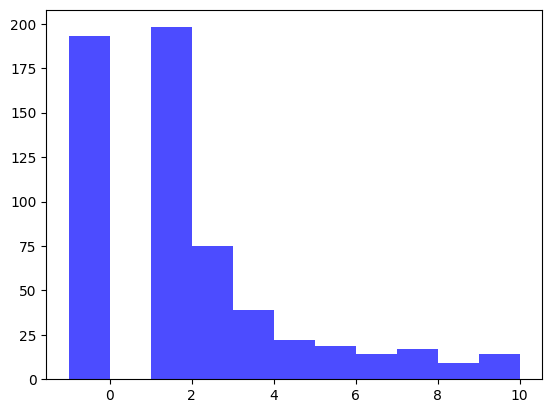

In [141]:
fig, ax = plt.subplots()
_ = ax.hist(df_eval['rank'], bins=11, color='blue', alpha=0.7)

In [178]:
# group by id and get median rank 
id2rank = df_eval.groupby('id')['rank'].median().to_dict()

In [210]:
ranks = np.array([id2rank.get(id_, np.nan) for id_ in df['id']])

In [242]:
ranks[~np.isnan(ranks)]

array([ 1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1., -1.,  3., -1.,  1., -1.,
       -1., 10.,  1.,  1., -1.,  3.,  1., -1.,  2., -1., -1., -1.,  2.,
        1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
        1.,  3.,  1., -1., -1.,  2.,  1.,  5.,  2.,  1.,  1., -1., -1.,
       -1.,  2.,  1., -1.,  1.,  5.,  1.,  2., -1., -1.,  1.,  3.,  4.,
        6.,  1.,  2.,  2.,  2.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
        1.,  3.,  2., -1.,  1.,  2.,  1.,  1.,  1.,  7.,  3.,  2.,  1.,
        1.,  2.,  4., -1.,  1.,  1.,  1., -1.,  2.,  1.,  1.,  1.,  1.,
       10.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  4.,  1.,  1., -1.,  3.,
        1.,  2.,  2.,  3.,  1.,  1., -1.,  2.,  2.,  3., -1., -1.,  2.,
       -1.,  1.,  1.,  1.,  1.,  2.,  2., -1.,  4.,  1.,  3.,  2.,  5.,
        1.,  5., -1.,  3.,  1.,  1., -1.,  3.,  1.,  1.,  3.,  1.,  1.,
        1.,  2.,  1.,  2.,  1., -1.,  3.,  1., -1.,  1.,  5.,  8

In [245]:
# create bins: <0, 0-3, 4-10
bins = np.array([0, 3])
# apply bins to ranks
c = np.digitize(ranks, bins)
cmap = {0: 'red', 1: 'blue', 2: 'yellow'}
c_str = np.array([cmap.get(i, 'black') for i in c])

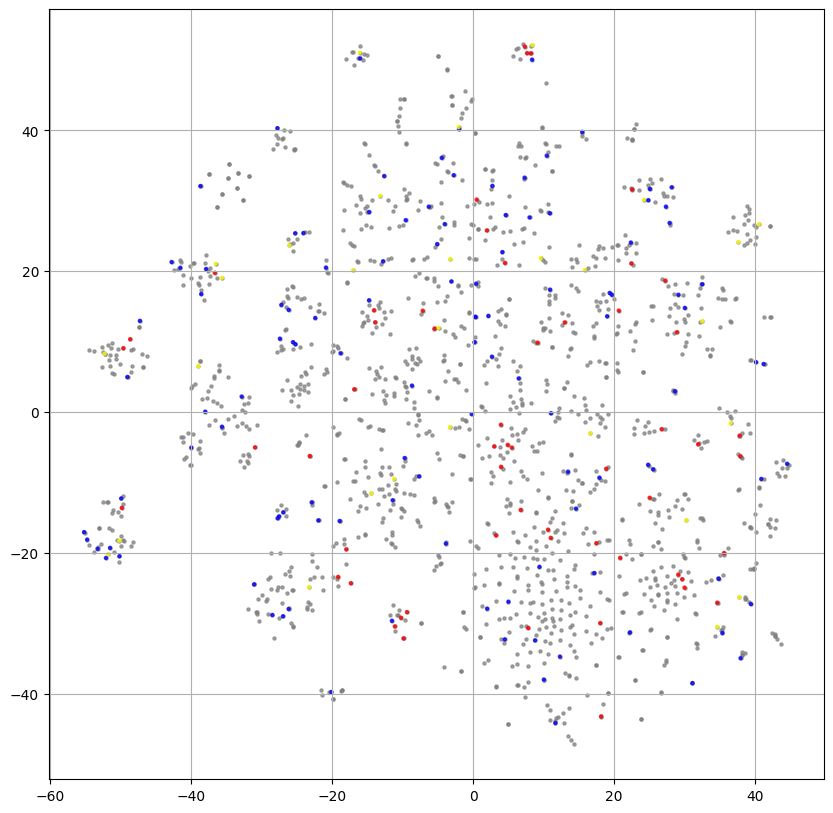

In [246]:
# plot embeddings, color-coded by median rank
fig, ax = plt.subplots(figsize=(10,10))
colored = ~np.isnan(ranks)
not_colored = np.setdiff1d(np.arange(len(X)), colored)
kwargs = dict(s=5, alpha=0.7)
ax.scatter(
    X_tsne[not_colored, 0], 
    X_tsne[not_colored, 1], 
    c='gray',
    **kwargs
)
ax.scatter(
    X_tsne[colored, 0], 
    X_tsne[colored, 1], 
    c=c_str[colored], 
    **kwargs
)
ax.grid()

In [142]:
df_eval.groupby('cluster_tsne')['rank'].apply(lambda x: (x == -1).sum()).sort_values(ascending=False)

cluster_tsne
2     20
17    20
0     19
16    18
15    15
3     12
9     12
12    10
18     9
6      9
4      8
1      6
5      6
11     6
7      5
14     5
8      4
10     3
13     3
19     3
Name: rank, dtype: int64

In [132]:
df_eval.query("cluster_tsne == 2").sample(
    5, random_state=42
)[['text', 'question', 'answer']].to_dict(orient='records')

[{'text': '::: llama_index.core.retrievers\n    options:\n      members:\n        - RecursiveRetriever',
  'question': 'What is the name of the retriever mentioned in this documentation?',
  'answer': 'RecursiveRetriever'},
 {'text': '::: llama_index.readers.llama_parse\n    options:\n      members:\n        - LlamaParse',
  'question': 'What is the name of the class found within the `llama_index.readers` module?',
  'answer': 'The class is called `LlamaParse`.'},
 {'text': '::: llama_index.tools.azure_code_interpreter\n    options:\n      members:\n        - AzureCodeInterpreterToolSpec',
  'question': 'If you were designing a system that utilized code interpreter tools, what potential design considerations might arise from the existence of tools like `AzureCodeInterpreterToolSpec`?',
  'answer': 'The existence of tools like `AzureCodeInterpreterToolSpec` suggests a need for careful management of code execution environments, security considerations for code running in Azure, and poten

In [247]:
# Ignoring -1s, what's the mean rank for each cluster?
df_eval.query('rank > 0').groupby('cluster_tsne')['rank'].mean().sort_values(ascending=False)#.head(10)

cluster_tsne
16    4.166667
0     3.363636
4     3.227273
10    3.148148
9     3.111111
15    2.933333
6     2.761905
11    2.750000
17    2.600000
13    2.555556
14    2.520000
2     2.500000
5     2.458333
19    2.444444
3     2.333333
1     2.333333
7     2.240000
8     2.115385
12    1.900000
18    1.809524
Name: rank, dtype: float64

In [248]:
df_eval.query('rank > 0').groupby('question_type')['rank'].mean()

question_type
analytical     2.602564
factual        2.570093
inferential    2.669565
Name: rank, dtype: float64

In [249]:
df_eval.query('rank > 0').groupby('difficulty')['rank'].mean()

difficulty
easy      2.479167
hard      2.597701
medium    2.710227
Name: rank, dtype: float64